In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import torch
from tqdm import tqdm

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount("GoogleDrive")

# Assuming the dataset is stored as a CSV file
df = pd.read_csv('GoogleDrive/MyDrive/SocialMediaTrendAnalysisDatasets/YoutubeTrends/USvideos.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at GoogleDrive


In [ ]:
import numpy as np
# Select relevant columns
df = df[['title', 'description', 'category_id', 'views', 'likes', 'dislikes', 'comment_count', 'trending_date']]

# Data Cleaning and Preprocessing
df['text'] = df['title'].fillna('') + ' ' + df['description'].fillna('')

threshold = 1000000
df['label'] = np.where(df['views'] > threshold, 1, 0)

In [ ]:
print(df.columns)
print(df.head())

Index(['title', 'description', 'category_id', 'views', 'likes', 'dislikes',
       'comment_count', 'trending_date', 'text', 'label'],
      dtype='object')
                                               title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE   
1  The Trump Presidency: Last Week Tonight with J...   
2  Racist Superman | Rudy Mancuso, King Bach & Le...   
3                   Nickelback Lyrics: Real or Fake?   
4                           I Dare You: GOING BALD!?   

                                         description  category_id    views  \
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...           22   748374   
1  One year after the presidential election, John...           24  2418783   
2  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...           23  3191434   
3  Today we find out if Link is a Nickelback amat...           24   343168   
4  I know it's been a while since we did this sho...           24  2095731   

    likes  dislikes  comment_count tr

In [ ]:
# Train-Validation-Test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


In [ ]:
# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset class
class YouTubeDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['text'])
        label = int(self.df.iloc[idx]['label'])

        encoding = self.tokenizer(text, truncation=True, max_length=self.max_len, padding='max_length', return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = YouTubeDataset(train_df, tokenizer)
val_dataset = YouTubeDataset(val_df, tokenizer)
test_dataset = YouTubeDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*5)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Evaluating: 100%|██████████| 1843/1843 [06:03<00:00,  5.08it/s]


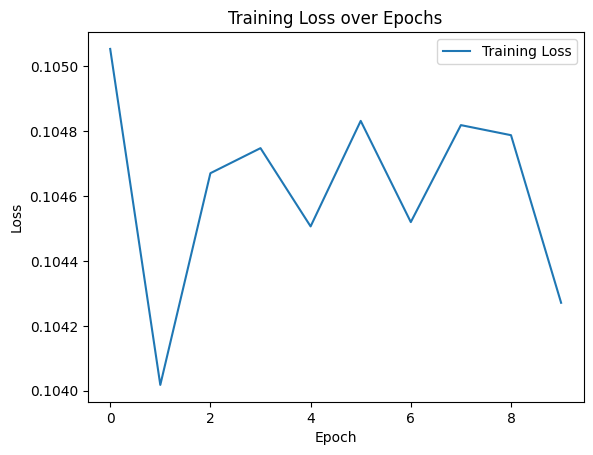

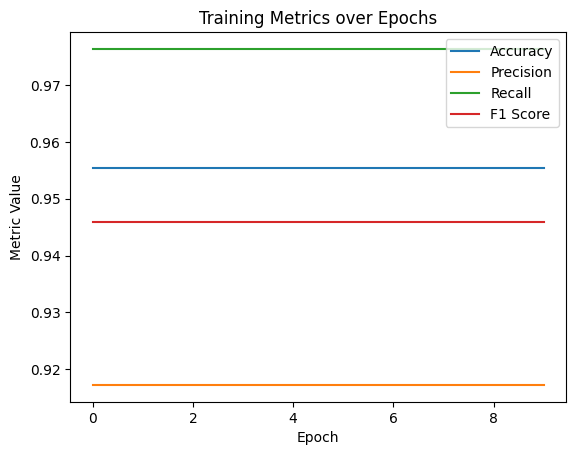

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Lists to store training loss and metrics
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []


# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    # Calculate metrics on training set
    train_labels, train_preds = evaluate(model, train_loader)
    train_preds_np = np.array(train_preds)
    train_accuracy = accuracy_score(train_labels, (train_preds_np > 0.5).astype(int))
    train_precision = precision_score(train_labels, (train_preds_np > 0.5).astype(int))
    train_recall = recall_score(train_labels, (train_preds_np > 0.5).astype(int))
    train_f1 = f1_score(train_labels, (train_preds_np > 0.5).astype(int))

    # Log training metrics
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

# Plot the Loss through epochs
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plot Training metrics over epochs
plt.plot(train_accuracies, label='Accuracy')
plt.plot(train_precisions, label='Precision')
plt.plot(train_recalls, label='Recall')
plt.plot(train_f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
import numpy as np
# Evaluation
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluation on Validation Set
val_labels, val_preds = evaluate(model, val_loader)

# Evaluation Metrics
val_preds_np = np.array(val_preds)
val_accuracy = accuracy_score(val_labels, (val_preds_np > 0.5).astype(int))
val_precision = precision_score(val_labels, (val_preds_np > 0.5).astype(int))
val_recall = recall_score(val_labels, (val_preds_np > 0.5).astype(int))
val_f1 = f1_score(val_labels, (val_preds_np > 0.5).astype(int))

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

# Evaluation on Test Set
test_labels, test_preds = evaluate(model, test_loader)

# Evaluation Metrics on Test Set
test_preds_np = np.array(test_preds)

# Evaluation Metrics on Test Set
test_accuracy = accuracy_score(test_labels, (test_preds_np > 0.5).astype(int))
test_precision = precision_score(test_labels, (test_preds_np > 0.5).astype(int))
test_recall = recall_score(test_labels, (test_preds_np > 0.5).astype(int))
test_f1 = f1_score(test_labels, (test_preds_np > 0.5).astype(int))

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Evaluating: 100%|██████████| 205/205 [00:40<00:00,  5.03it/s]


Validation Accuracy: 0.9356
Validation Precision: 0.8929
Validation Recall: 0.9503
Validation F1 Score: 0.9207


Evaluating: 100%|██████████| 512/512 [01:41<00:00,  5.07it/s]

Test Accuracy: 0.9376
Test Precision: 0.8963
Test Recall: 0.9554
Test F1 Score: 0.9249


In [ ]:
# Print class distribution in validation set
print("Validation Set Class Distribution:")
print(val_df['label'].value_counts())

# Print class distribution in test set
print("\nTest Set Class Distribution:")
print(test_df['label'].value_counts())

# Print predictions for a few instances in validation set
for i in range(5):
    print(f"\nInstance {i + 1} - True Label: {val_labels[i]}, Predicted Probability: {val_preds[i]}, Predicted Class: {int(val_preds[i] > 0.5)}")

# Print predictions for a few instances in test set
for i in range(5):
    print(f"\nInstance {i + 1} - True Label: {test_labels[i]}, Predicted Probability: {test_preds[i]}, Predicted Class: {int(test_preds[i] > 0.5)}")


Validation Set Class Distribution:
0    1987
1    1289
Name: label, dtype: int64

Test Set Class Distribution:
0    4897
1    3293
Name: label, dtype: int64

Instance 1 - True Label: 1, Predicted Probability: 0.9917429089546204, Predicted Class: 1

Instance 2 - True Label: 0, Predicted Probability: 0.00031743975705467165, Predicted Class: 0

Instance 3 - True Label: 0, Predicted Probability: 0.8829202651977539, Predicted Class: 1

Instance 4 - True Label: 0, Predicted Probability: 0.0002924152940977365, Predicted Class: 0

Instance 5 - True Label: 1, Predicted Probability: 0.998309850692749, Predicted Class: 1

Instance 1 - True Label: 0, Predicted Probability: 0.0004677549877669662, Predicted Class: 0

Instance 2 - True Label: 0, Predicted Probability: 0.09695863723754883, Predicted Class: 0

Instance 3 - True Label: 1, Predicted Probability: 0.768551766872406, Predicted Class: 1

Instance 4 - True Label: 0, Predicted Probability: 0.001454933313652873, Predicted Class: 0

Instance 5 -

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for validation set
val_conf_matrix = confusion_matrix(val_labels, (val_preds_np > 0.5).astype(int))
print("Validation Confusion Matrix:")
print(val_conf_matrix)

# Calculate confusion matrix for test set
test_conf_matrix = confusion_matrix(test_labels, (test_preds_np > 0.5).astype(int))
print("\nTest Confusion Matrix:")
print(test_conf_matrix)

Validation Confusion Matrix:
[[1840  147]
 [  64 1225]]

Test Confusion Matrix:
[[4533  364]
 [ 147 3146]]
